# Background at LGS channel

## Thermal flux

Thermal flux is computed for the LGS channel as

$F_{th} = B(T) \ \epsilon_{tot} \ \Omega \ \dfrac{\pi}{4} \ d^2$ 

where $B(T)$ is the blackbody radiance, $\epsilon_{tot}$ is the total emissivity (i.e. emissivity of telescope + MORFEO up to LGS channel included), $\Omega$ is the solid angle subtended by the LGS WFS lenslet array and $d$ is the lenslet array size.

$\underline{NOTE}$: Flux unit is PHOTLAM from synphot, defined as: PHOTLAM = ph/s/cm$^2$/Angstrom.

  points: [3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700. 4800. 4900.
 5000. 5100. 5200. 5300. 5400. 5500.]
  lookup_table: [-1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16] [synphot.models]
/var/folders/bz/hhfc34sj5m53p6z7z2vq77jh0000gn/T/ipykernel_57656/628177638.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 44000)


PHOTLAM = ph/s/cm$^2$/Angstrom


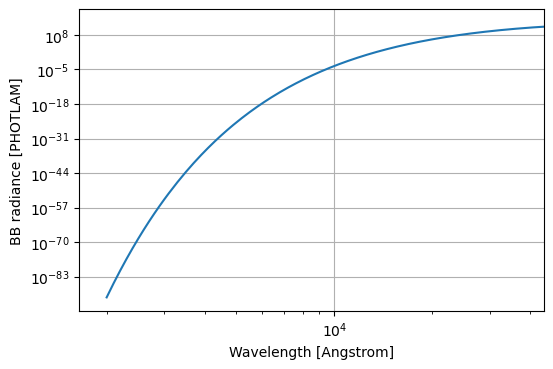

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from synphot.models import BlackBody1D, Empirical1D
from synphot import SourceSpectrum, units
from arte.photometry.transmissive_elements import MorfeoLgsChannelAsTransmissiveElement, MorfeoTransmissiveElementsCatalog

lgs_ch = MorfeoLgsChannelAsTransmissiveElement()
waveset = lgs_ch.transmittance.waveset

#BLACKBODY SPECTRUM
T = 278.15 * u.K
bb = SourceSpectrum(BlackBody1D, temperature=T)

mpl.rcParams['figure.dpi'] = 100
plt.loglog(waveset, bb(waveset))
plt.grid()
plt.ylabel('BB radiance [%s]' %bb(waveset).unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.xlim(0, 44000)
# plt.ylim(1e-25, 1e20)

print('PHOTLAM = ph/s/cm$^2$/Angstrom')

In [2]:
#PARAMETERS
lenslet_diam = 30 * u.mm
lenslet_f = 3.21125* u.mm
px_size = 24 * u.um
solid_angle = np.pi / 4 * lenslet_diam**2 / (lenslet_f**2 + (lenslet_diam/2)**2) * u.sr
print(solid_angle)

3.0039180614432066 sr


Text(0.5, 0, 'Wavelength [Angstrom]')

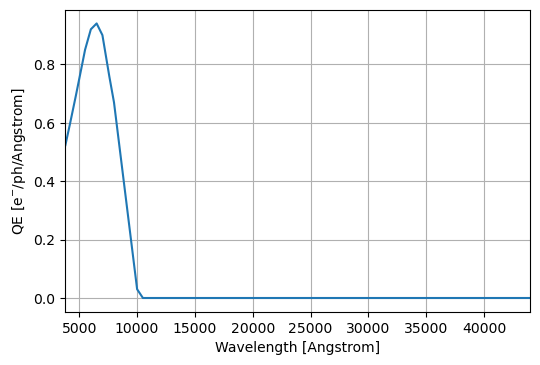

In [3]:
ccd220 = MorfeoTransmissiveElementsCatalog.ccd220_qe()

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, ccd220.transmittance(waveset))
plt.grid()
plt.xlim(3800, 44000)
plt.ylabel('QE [e$^{-}$/ph/Angstrom]')
plt.xlabel('Wavelength [%s]' %waveset.unit)

9699.999999999998 Angstrom
3.298602591436456e-12 cm2 PHOTLAM
2.456050893533089e-09 Angstrom cm2 PHOTLAM


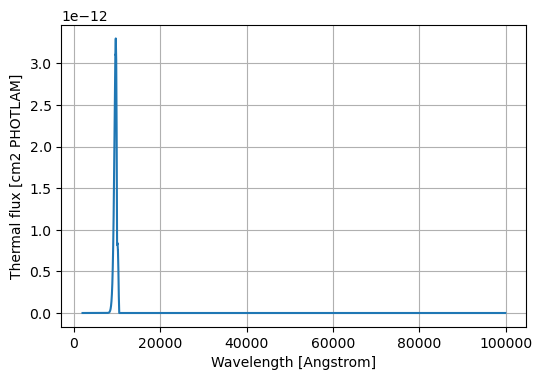

In [4]:
#THERMAL FLUX AT LGS CHANNEL
# photlam_explicit = u.ph / u.s / u.cm**2 / u.Angstrom / units.PHOTLAM
th_flux = (bb * lgs_ch.emissivity * ccd220.transmittance)(waveset) * solid_angle.value * (px_size.to(u.cm))**2

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, th_flux)
plt.grid()
plt.ylabel('Thermal flux [%s]' %th_flux.unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)

print(waveset[np.argmax(th_flux)])
print(th_flux[np.argmax(th_flux)])
print(np.trapz(th_flux, waveset))

## Sky flux

Sky flux is computed as:

$F_{sky} = S \ T_{tot} \ \dfrac{D}{N_{subap}} \ p^2$ 

where $S$ is the night sky radiance in [ph/s/m$^2$/$\mu$m/arcsec$^2$], $T_{tot}$ is the total transmission (i.e. transmission of telescope + MORFEO up to LGS channel included), $D$ is the telescope diameter, $N_{subap}$ is the number of subapertures and $p$ is pixel-scale.

Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)
Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)


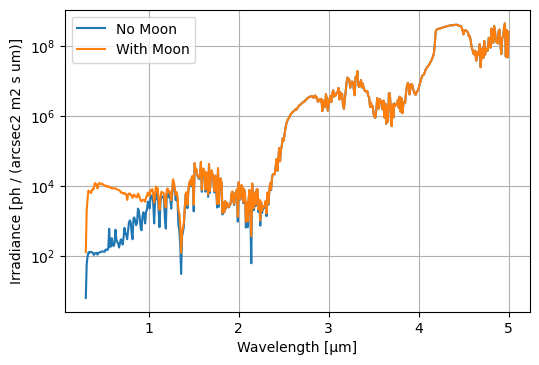

In [5]:
from arte.photometry.eso_sky_calc import EsoSkyCalc

zenith_angle = 30 * u.deg
airmass = 1 / np.cos(zenith_angle.to(u.rad))
sky_no_moon = EsoSkyCalc(airmass = airmass, incl_moon = 'N')
sky_fullmoon = EsoSkyCalc(airmass = airmass, incl_moon = 'Y', moon_sun_sep=180)

plt.semilogy(sky_no_moon.lam.to(u.um), sky_no_moon.flux, label='No Moon')
plt.semilogy(sky_fullmoon.lam.to(u.um), sky_fullmoon.flux, label='With Moon')
plt.grid()
plt.xlabel('Wavelength [μm]')
plt.ylabel('Irradiance [%s]' %sky_fullmoon.flux.unit)
plt.legend()

In [6]:
px_scale = 1.2 * u.arcsec

sky_flux_no_moon = sky_no_moon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_flux_fullmoon = sky_fullmoon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_ss_no_moon = SourceSpectrum(Empirical1D, points=sky_no_moon.lam, lookup_table=sky_flux_no_moon)
sky_ss_fullmoon = SourceSpectrum(Empirical1D, points=sky_fullmoon.lam, lookup_table=sky_flux_fullmoon)

0.0026886822352938447 cm2 PHOTLAM
0.07085661780991111 cm2 PHOTLAM


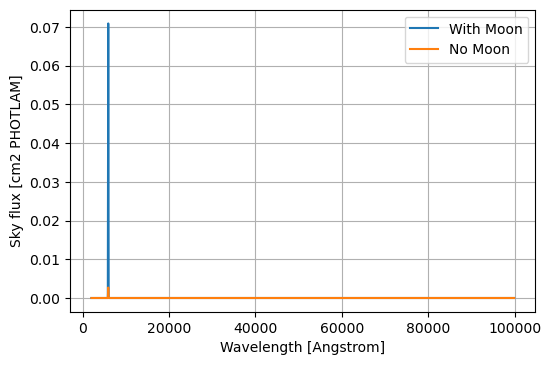

In [7]:
D_tel = 38.54 * u.m
N_subap = 68

sky_no_moon_at_ccd = (sky_ss_no_moon * lgs_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
sky_fullmoon_at_ccd = (sky_ss_fullmoon * lgs_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
plt.plot(waveset, sky_fullmoon_at_ccd, label='With Moon')
plt.plot(waveset, sky_no_moon_at_ccd, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Sky flux [%s]' %sky_fullmoon_at_ccd.unit)
plt.legend()
print(sky_no_moon_at_ccd.max())
print(sky_fullmoon_at_ccd.max())

## Total background

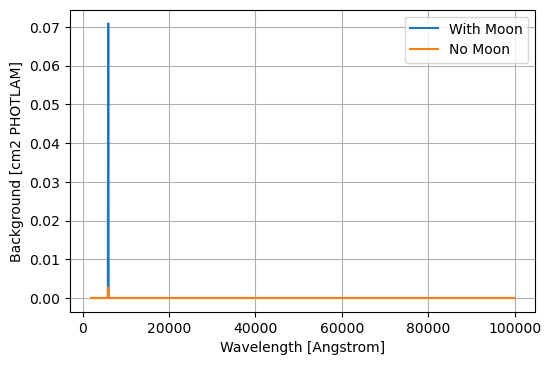

In [8]:
bkg_no_moon = th_flux + sky_no_moon_at_ccd
bkg_fullmoon = th_flux + sky_fullmoon_at_ccd

plt.plot(waveset, bkg_fullmoon, label='With Moon')
plt.plot(waveset, bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

In [9]:
print('Background without Moon: %s' %np.trapz(bkg_no_moon, waveset))
print('Background with Moon: %s' %np.trapz(bkg_fullmoon, waveset))

Background without Moon: 0.2688682259854354 Angstrom cm2 PHOTLAM
Background with Moon: 7.085661783447161 Angstrom cm2 PHOTLAM


# Background at Reference channel

  points: [3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700. 4800. 4900.
 5000. 5100. 5200. 5300. 5400. 5500.]
  lookup_table: [-1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16] [synphot.models]
  points: [5200.]
  lookup_table: [-0.45] [synphot.models]
/var/folders/bz/hhfc34sj5m53p6z7z2vq77jh0000gn/T/ipykernel_57656/1775980677.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 44000)


(1644.7625960721032, 44000)

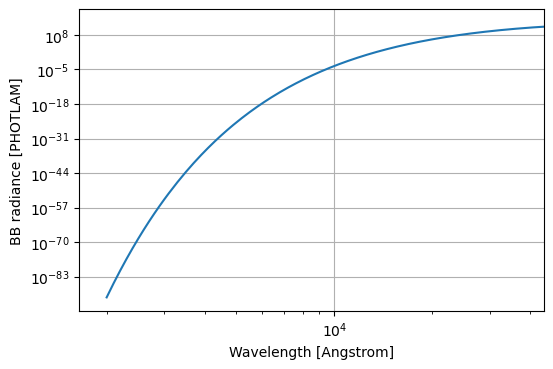

In [10]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from synphot.models import BlackBody1D, Empirical1D
from synphot import SourceSpectrum, units
from arte.photometry.transmissive_elements import MorfeoReferenceChannelAsTransmissiveElement, MorfeoTransmissiveElementsCatalog

r_ch = MorfeoReferenceChannelAsTransmissiveElement()
waveset = r_ch.transmittance.waveset

#BLACKBODY SPECTRUM
T = 278.15 * u.K
bb = SourceSpectrum(BlackBody1D, temperature=T)

mpl.rcParams['figure.dpi'] = 100
plt.loglog(waveset, bb(waveset))
plt.grid()
plt.ylabel('BB radiance [%s]' %bb(waveset).unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.xlim(0, 44000)

In [11]:
#PARAMETERS
lenslet_diam = 5.76 * u.mm
lenslet_f = 8.8 * u.mm
px_size = 24 * u.um
solid_angle = np.pi / 4 * lenslet_diam**2 / (lenslet_f**2 + (lenslet_diam/2)**2) * u.sr
print(solid_angle)

0.3039343146500725 sr


Text(0.5, 0, 'Wavelength [Angstrom]')

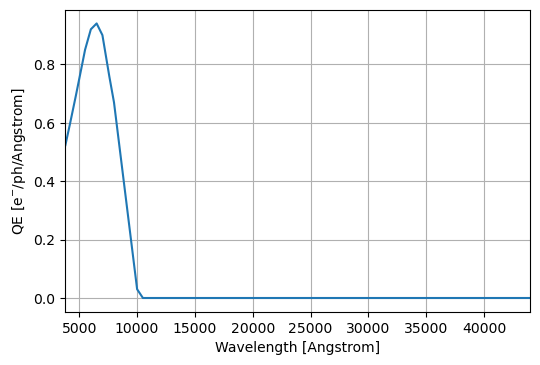

In [12]:
ccd220 = MorfeoTransmissiveElementsCatalog.ccd220_qe()

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, ccd220.transmittance(waveset))
plt.grid()
plt.xlim(3800, 44000)
plt.ylabel('QE [e$^{-}$/ph/Angstrom]')
plt.xlabel('Wavelength [%s]' %waveset.unit)

9699.999999999998 Angstrom
7.338992143791473e-13 cm2 PHOTLAM
5.540115072086487e-10 Angstrom cm2 PHOTLAM


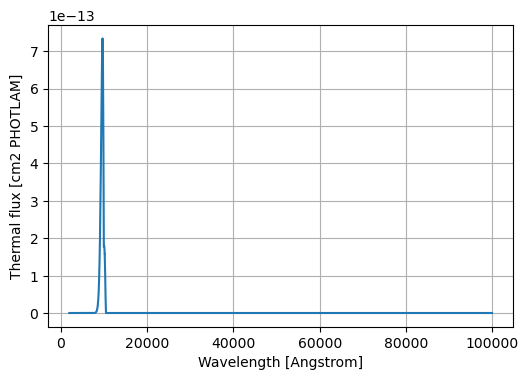

In [13]:
#THERMAL FLUX AT REFERENCE CHANNEL
th_flux = (bb * r_ch.emissivity * ccd220.transmittance)(waveset) * solid_angle.value * (px_size.to(u.cm))**2

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, th_flux)
plt.grid()
plt.ylabel('Thermal flux [%s]' %th_flux.unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)

print(waveset[np.argmax(th_flux)])
print(th_flux[np.argmax(th_flux)])
print(np.trapz(th_flux, waveset))

## Sky flux

Sky flux is computed as:

$F_{sky} = S \ T_{tot} \ \dfrac{D}{N_{subap}} \ p^2$ 

where $S$ is the night sky radiance in [ph/s/m$^2$/$\mu$m/arcsec$^2$], $T_{tot}$ is the total transmission (i.e. transmission of telescope + MORFEO up to LGS channel included), $D$ is the telescope diameter, $N_{subap}$ is the number of subapertures and $p$ is pixel-scale.

Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)
Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)


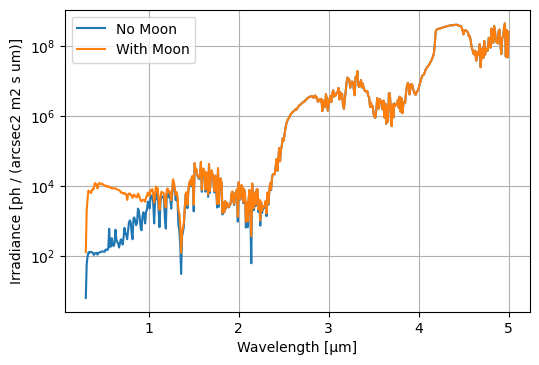

In [14]:
from arte.photometry.eso_sky_calc import EsoSkyCalc

zenith_angle = 30 * u.deg
airmass = 1 / np.cos(zenith_angle.to(u.rad))
sky_no_moon = EsoSkyCalc(airmass = airmass, incl_moon = 'N')
sky_fullmoon = EsoSkyCalc(airmass = airmass, incl_moon = 'Y', moon_sun_sep=180)

plt.semilogy(sky_no_moon.lam.to(u.um), sky_no_moon.flux, label='No Moon')
plt.semilogy(sky_fullmoon.lam.to(u.um), sky_fullmoon.flux, label='With Moon')
plt.grid()
plt.xlabel('Wavelength [μm]')
plt.ylabel('Irradiance [%s]' %sky_fullmoon.flux.unit)
plt.legend()

In [15]:
px_scale = 0.15 * u.arcsec

sky_flux_no_moon = sky_no_moon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_flux_fullmoon = sky_fullmoon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_ss_no_moon = SourceSpectrum(Empirical1D, points=sky_no_moon.lam, lookup_table=sky_flux_no_moon)
sky_ss_fullmoon = SourceSpectrum(Empirical1D, points=sky_fullmoon.lam, lookup_table=sky_flux_fullmoon)

0.009609934756524522 cm2 PHOTLAM
0.05107256879207935 cm2 PHOTLAM


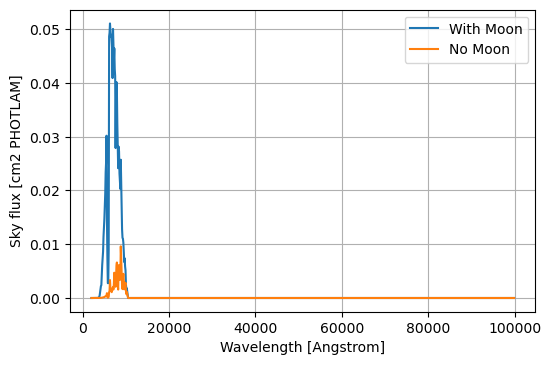

In [16]:
D_tel = 38.54 * u.m
N_subap = 10

sky_no_moon_at_ccd = (sky_ss_no_moon * r_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
sky_fullmoon_at_ccd = (sky_ss_fullmoon * r_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
plt.plot(waveset, sky_fullmoon_at_ccd, label='With Moon')
plt.plot(waveset, sky_no_moon_at_ccd, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Sky flux [%s]' %sky_fullmoon_at_ccd.unit)
plt.legend()
print(sky_no_moon_at_ccd.max())
print(sky_fullmoon_at_ccd.max())

## Total background

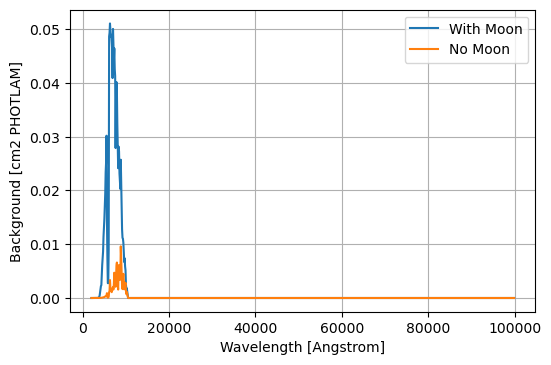

In [17]:
bkg_no_moon = th_flux + sky_no_moon_at_ccd
bkg_fullmoon = th_flux + sky_fullmoon_at_ccd

plt.plot(waveset, bkg_fullmoon, label='With Moon')
plt.plot(waveset, bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

In [18]:
print('Background without Moon: %s' %np.trapz(bkg_no_moon, waveset))
print('Background with Moon: %s' %np.trapz(bkg_fullmoon, waveset))

Background without Moon: 13.741235401186598 Angstrom cm2 PHOTLAM
Background with Moon: 142.7298951127404 Angstrom cm2 PHOTLAM


# Background at Low Order channel

  points: [3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700. 4800. 4900.
 5000. 5100. 5200. 5300. 5400. 5500.]
  lookup_table: [-1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16] [synphot.models]
  points: [5200.]
  lookup_table: [-0.45] [synphot.models]
/var/folders/bz/hhfc34sj5m53p6z7z2vq77jh0000gn/T/ipykernel_57656/1592215417.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 44000)


(1644.7625960721032, 44000)

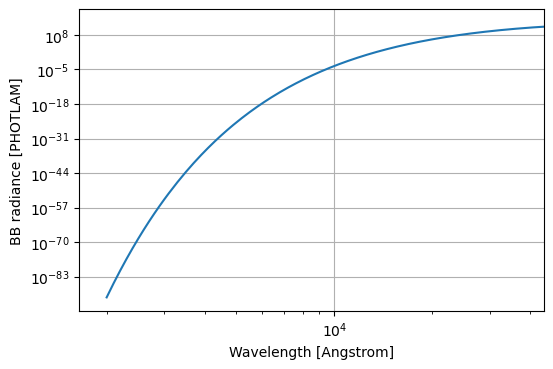

In [19]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from synphot.models import BlackBody1D, Empirical1D
from synphot import SourceSpectrum, units
from arte.photometry.transmissive_elements import MorfeoLowOrderChannelAsTransmissiveElement, MorfeoTransmissiveElementsCatalog

lo_ch = MorfeoLowOrderChannelAsTransmissiveElement()
waveset = lo_ch.transmittance.waveset

#BLACKBODY SPECTRUM
T = 278.15 * u.K
bb = SourceSpectrum(BlackBody1D, temperature=T)

mpl.rcParams['figure.dpi'] = 100
plt.loglog(waveset, bb(waveset))
plt.grid()
plt.ylabel('BB radiance [%s]' %bb(waveset).unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.xlim(0, 44000)

In [20]:
#PARAMETERS
lenslet_diam = 5.76 * u.mm
lenslet_f = 87.7 * u.mm
px_size = 24 * u.um
cs_oversiz = 0.65
cs_ccd = 38.83 * u.mm
solid_angle_pup = np.pi / 4 * lenslet_diam**2 / (lenslet_f**2 + (lenslet_diam/2)**2) * u.sr
solid_angle_cam = np.pi / 4 * (lenslet_diam * (1 + cs_oversiz))**2 / (
                        cs_ccd**2 + (lenslet_diam * (1 + cs_oversiz) / 2)**2) * u.sr
print(solid_angle_pup)
print(solid_angle_cam)

0.0033842899502387657 sr
0.046356629754847 sr


Text(0.5, 0, 'Wavelength [Angstrom]')

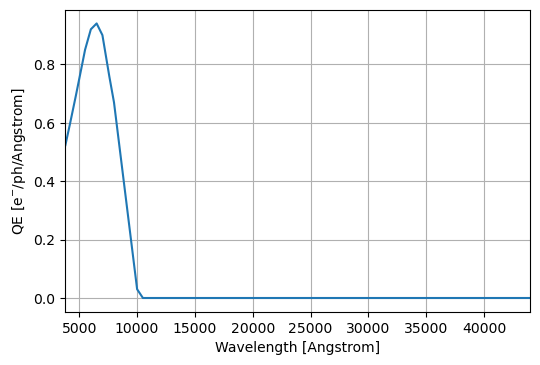

In [21]:
c_red1_qe = MorfeoTransmissiveElementsCatalog.c_red_one_qe()
c_red1_filt = MorfeoTransmissiveElementsCatalog.c_red_one_filters()

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, ccd220.transmittance(waveset))
plt.grid()
plt.xlim(3800, 44000)
plt.ylabel('QE [e$^{-}$/ph/Angstrom]')
plt.xlabel('Wavelength [%s]' %waveset.unit)

9699.999999999998 Angstrom
7.338992143791473e-13 cm2 PHOTLAM
5.540115072086487e-10 Angstrom cm2 PHOTLAM


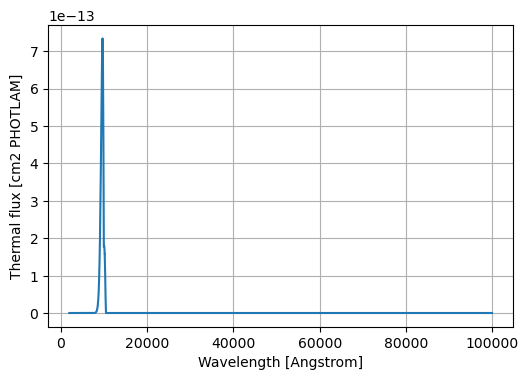

In [22]:
#THERMAL FLUX AT REFERENCE CHANNEL
th_flux = (bb * r_ch.emissivity * ccd220.transmittance)(waveset) * solid_angle.value * (px_size.to(u.cm))**2

mpl.rcParams['figure.dpi'] = 100
plt.plot(waveset, th_flux)
plt.grid()
plt.ylabel('Thermal flux [%s]' %th_flux.unit)
plt.xlabel('Wavelength [%s]' %waveset.unit)

print(waveset[np.argmax(th_flux)])
print(th_flux[np.argmax(th_flux)])
print(np.trapz(th_flux, waveset))

## Sky flux

Sky flux is computed as:

$F_{sky} = S \ T_{tot} \ \dfrac{D}{N_{subap}} \ p^2$ 

where $S$ is the night sky radiance in [ph/s/m$^2$/$\mu$m/arcsec$^2$], $T_{tot}$ is the total transmission (i.e. transmission of telescope + MORFEO up to LGS channel included), $D$ is the telescope diameter, $N_{subap}$ is the number of subapertures and $p$ is pixel-scale.

Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)
Note: skycalc_cli v.1.4 output wavelength unit is nm (it is μm in v.1.3)


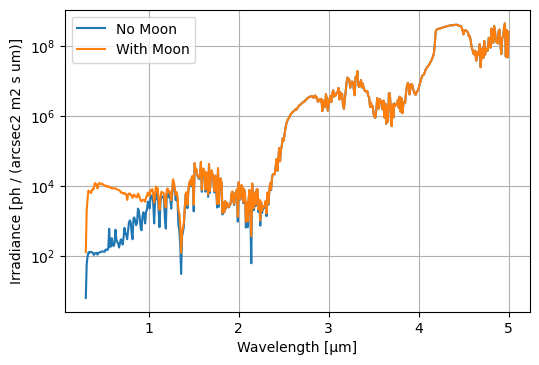

In [23]:
from arte.photometry.eso_sky_calc import EsoSkyCalc

zenith_angle = 30 * u.deg
airmass = 1 / np.cos(zenith_angle.to(u.rad))
sky_no_moon = EsoSkyCalc(airmass = airmass, incl_moon = 'N')
sky_fullmoon = EsoSkyCalc(airmass = airmass, incl_moon = 'Y', moon_sun_sep=180)

plt.semilogy(sky_no_moon.lam.to(u.um), sky_no_moon.flux, label='No Moon')
plt.semilogy(sky_fullmoon.lam.to(u.um), sky_fullmoon.flux, label='With Moon')
plt.grid()
plt.xlabel('Wavelength [μm]')
plt.ylabel('Irradiance [%s]' %sky_fullmoon.flux.unit)
plt.legend()

In [24]:
px_scale = 0.15 * u.arcsec

sky_flux_no_moon = sky_no_moon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_flux_fullmoon = sky_fullmoon.flux.to(u.ph/u.arcsec**2/u.cm**2/u.s/u.Angstrom) * px_scale**2
sky_ss_no_moon = SourceSpectrum(Empirical1D, points=sky_no_moon.lam, lookup_table=sky_flux_no_moon)
sky_ss_fullmoon = SourceSpectrum(Empirical1D, points=sky_fullmoon.lam, lookup_table=sky_flux_fullmoon)

0.009609934756524522 cm2 PHOTLAM
0.05107256879207935 cm2 PHOTLAM


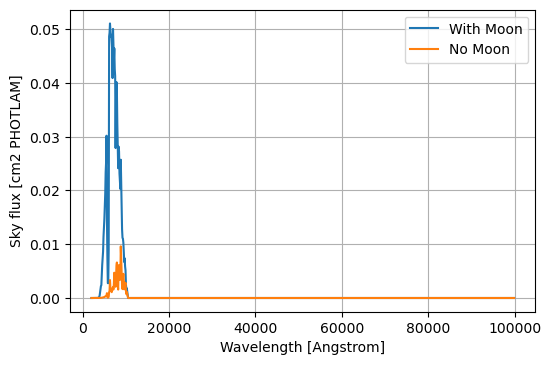

In [25]:
D_tel = 38.54 * u.m
N_subap = 10

sky_no_moon_at_ccd = (sky_ss_no_moon * r_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
sky_fullmoon_at_ccd = (sky_ss_fullmoon * r_ch.transmittance)(waveset) * (D_tel.to(u.cm) / N_subap)**2
plt.plot(waveset, sky_fullmoon_at_ccd, label='With Moon')
plt.plot(waveset, sky_no_moon_at_ccd, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Sky flux [%s]' %sky_fullmoon_at_ccd.unit)
plt.legend()
print(sky_no_moon_at_ccd.max())
print(sky_fullmoon_at_ccd.max())

## Total background

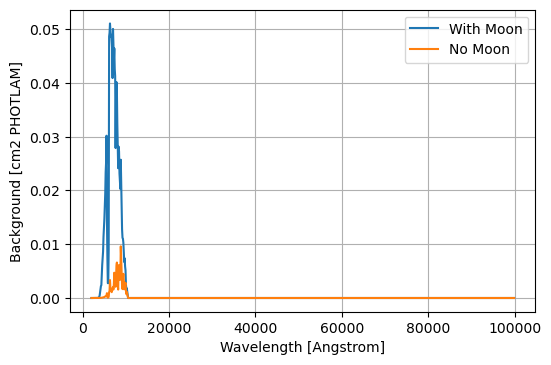

In [26]:
bkg_no_moon = th_flux + sky_no_moon_at_ccd
bkg_fullmoon = th_flux + sky_fullmoon_at_ccd

plt.plot(waveset, bkg_fullmoon, label='With Moon')
plt.plot(waveset, bkg_no_moon, label='No Moon')
plt.grid()
plt.xlabel('Wavelength [%s]' %waveset.unit)
plt.ylabel('Background [%s]' %bkg_fullmoon.unit)
plt.legend()

In [27]:
print('Background without Moon: %s' %np.trapz(bkg_no_moon, waveset))
print('Background with Moon: %s' %np.trapz(bkg_fullmoon, waveset))

Background without Moon: 13.741235401186598 Angstrom cm2 PHOTLAM
Background with Moon: 142.7298951127404 Angstrom cm2 PHOTLAM
